In [1]:
import gym, random, pickle, os.path, math, glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import pdb

from atari_wrappers import make_atari, wrap_deepmind
from IPython.display import clear_output
from tensorboardX import SummaryWriter

USE_CUDA = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

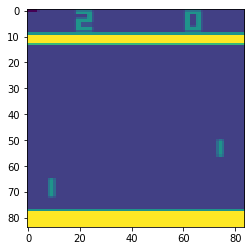

In [2]:
# Create and wrap the environment
env = make_atari('PongNoFrameskip-v4') # only use in no frameskip environment
env = wrap_deepmind(env, scale = False, frame_stack=True )
n_actions = env.action_space.n
state_dim = env.observation_space.shape

# env.render()
test = env.reset()
for i in range(100):
    test = env.step(env.action_space.sample())[0]

plt.imshow(test._force()[...,0])

#plt.imshow(env.render("rgb_array"))
# env.close()

In [3]:
class DQN(nn.Module):
    def __init__(self, in_channels=4, num_actions=5):
        """
        Initialize a deep Q-learning network as described in
        https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf
        Arguments:
            in_channels: number of channel of input.
                i.e The number of most recent frames stacked together as describe in the paper
            num_actions: number of action-value to output, one-to-one correspondence to action in game.
        """
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(7 * 7 * 64, 512)
        self.fc5 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.view(x.size(0), -1)))
        return self.fc5(x)


In [4]:
# SumTree
# a binary tree data structure where the parent’s value is the sum of its children
class SumTree:
    write = 0

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.n_entries = 0

    # update to the root node
    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    # find sample on leaf node
    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        return self.tree[0]

    # store priority and sample
    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

        if self.n_entries < self.capacity:
            self.n_entries += 1

    # update priority
    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    # get priority and sample
    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])


In [5]:
class Memory_Buffer_PER(object):
    # stored as ( s, a, r, s_ ) in SumTree
    def __init__(self, memory_size=1000, a = 0.6, e = 0.01):
        self.tree =  SumTree(memory_size)
        self.memory_size = memory_size
        self.prio_max = 0.1
        self.a = a
        self.e = e
        
    def push(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        p = (np.abs(self.prio_max) + self.e) ** self.a #  proportional priority
        self.tree.add(p, data)

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        idxs = []
        segment = self.tree.total() / batch_size
        priorities = []

        for i in range(batch_size):
            a = segment * i
            b = segment * (i + 1)
            s = random.uniform(a, b)
            idx, p, data = self.tree.get(s)
            
            state, action, reward, next_state, done= data
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
            priorities.append(p)
            idxs.append(idx)
        return idxs, np.concatenate(states), actions, rewards, np.concatenate(next_states), dones
    
    def update(self, idxs, errors):
        self.prio_max = max(self.prio_max, max(np.abs(errors)))
        for i, idx in enumerate(idxs):
            p = (np.abs(errors[i]) + self.e) ** self.a
            self.tree.update(idx, p) 
        
    def size(self):
        return self.tree.n_entries


In [6]:
class DQN_PERAgent: 
    def __init__(self, in_channels = 1, action_space = None, USE_CUDA = False, memory_size = 10000, prio_a = 0.6, prio_e = 0.001, epsilon  = 1, lr = 1e-4):
        self.epsilon = epsilon
        self.action_space = action_space
        self.memory_buffer = Memory_Buffer_PER(memory_size, a = prio_a, e = prio_e)
        self.DQN = DQN(in_channels = in_channels, num_actions = action_space.n)
        self.DQN_target = DQN(in_channels = in_channels, num_actions = action_space.n)
        self.DQN_target.load_state_dict(self.DQN.state_dict())


        self.USE_CUDA = USE_CUDA
        if USE_CUDA:
            self.DQN = self.DQN.cuda()
            self.DQN_target = self.DQN_target.cuda()
        self.optimizer = optim.RMSprop(self.DQN.parameters(),lr=lr, eps=0.001, alpha=0.95)

    def observe(self, lazyframe):
        # from Lazy frame to tensor
        state =  torch.from_numpy(lazyframe._force().transpose(2,0,1)[None]/255).float()
        if self.USE_CUDA:
            state = state.cuda()
        return state

    def value(self, state):
        q_values = self.DQN(state)
        return q_values
    
    def act(self, state, epsilon = None):
        """
        sample actions with epsilon-greedy policy
        recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
        """
        if epsilon is None: epsilon = self.epsilon

        q_values = self.value(state).cpu().detach().numpy()
        if random.random()<epsilon:
            aciton = random.randrange(self.action_space.n)
        else:
            aciton = q_values.argmax(1)[0]
        return aciton
    
    def compute_td_loss(self,idxs, states, actions, rewards, next_states, is_done, gamma=0.99):
        """ Compute td loss using torch operations only. Use the formula above. """
        actions = torch.tensor(actions).long()    # shape: [batch_size]
        rewards = torch.tensor(rewards, dtype =torch.float)  # shape: [batch_size]
        is_done = torch.tensor(is_done).bool()  # shape: [batch_size]
        
        if self.USE_CUDA:
            actions = actions.cuda()
            rewards = rewards.cuda()
            is_done = is_done.cuda()

        # get q-values for all actions in current states
        predicted_qvalues = self.DQN(states)

        # select q-values for chosen actions
        predicted_qvalues_for_actions = predicted_qvalues[
          range(states.shape[0]), actions
        ]

        # compute q-values for all actions in next states
        predicted_next_qvalues = self.DQN_target(next_states) # YOUR CODE

        # compute V*(next_states) using predicted next q-values
        next_state_values =  predicted_next_qvalues.max(-1)[0] # YOUR CODE

        # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
        target_qvalues_for_actions = rewards + gamma *next_state_values # YOUR CODE

        # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
        target_qvalues_for_actions = torch.where(
            is_done, rewards, target_qvalues_for_actions)

        # mean squared error loss to minimize
        errors = (predicted_qvalues_for_actions - target_qvalues_for_actions).detach().cpu().squeeze().tolist()
        self.memory_buffer.update(idxs, errors)
        loss = F.smooth_l1_loss(predicted_qvalues_for_actions, target_qvalues_for_actions.detach())

        return loss
    
    def sample_from_buffer(self, batch_size):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        idxs = []
        segment = self.memory_buffer.tree.total() / batch_size
        priorities = []

        for i in range(batch_size):
            a = segment * i
            b = segment * (i + 1)
            s = random.uniform(a, b)
            idx, p, data = self.memory_buffer.tree.get(s)
            
            frame, action, reward, next_frame, done= data
            states.append(self.observe(frame))
            actions.append(action)
            rewards.append(reward)
            next_states.append(self.observe(next_frame))
            dones.append(done)
            priorities.append(p)
            idxs.append(idx)
        return idxs, torch.cat(states), actions, rewards, torch.cat(next_states), dones

    def learn_from_experience(self, batch_size):
        if self.memory_buffer.size() > batch_size:
            idxs, states, actions, rewards, next_states, dones = self.sample_from_buffer(batch_size)
            td_loss = self.compute_td_loss(idxs, states, actions, rewards, next_states, dones)
            self.optimizer.zero_grad()
            td_loss.backward()
            for param in self.DQN.parameters():
                param.grad.data.clamp_(-1, 1)

            self.optimizer.step()
            return(td_loss.item())
        else:
            return(0)
    

In [7]:
# if __name__ == '__main__':
    
# Training DQN in PongNoFrameskip-v4 
env = make_atari('PongNoFrameskip-v4')
env = wrap_deepmind(env, scale = False, frame_stack=True)

gamma = 0.99
epsilon_max = 1
epsilon_min = 0.01
eps_decay = 30000
frames = 1000000
USE_CUDA = True
learning_rate = 2e-4
max_buff = 100000
update_tar_interval = 1000
batch_size = 32
print_interval = 1000
log_interval = 1000
learning_start = 10000
win_reward = 18     # Pong-v4
win_break = True

action_space = env.action_space
action_dim = env.action_space.n
state_dim = env.observation_space.shape[0]
state_channel = env.observation_space.shape[2]
agent = DQN_PERAgent(in_channels = state_channel, action_space= action_space, USE_CUDA = USE_CUDA, lr = learning_rate)

frame = env.reset()

episode_reward = 0
all_rewards = []
losses = []
episode_num = 0
is_win = False
# tensorboard
summary_writer = SummaryWriter(log_dir = "DQN_PER", comment= "good_makeatari")

# e-greedy decay
epsilon_by_frame = lambda frame_idx: epsilon_min + (epsilon_max - epsilon_min) * math.exp(
            -1. * frame_idx / eps_decay)
# plt.plot([epsilon_by_frame(i) for i in range(10000)])

for i in range(frames):
    epsilon = epsilon_by_frame(i)
    state_tensor = agent.observe(frame)
    action = agent.act(state_tensor, epsilon)
    
    next_frame, reward, done, _ = env.step(action)
    
    episode_reward += reward
    agent.memory_buffer.push(frame, action, reward, next_frame, done)
    frame = next_frame
    
    loss = 0
    if agent.memory_buffer.size() >= learning_start:
        loss = agent.learn_from_experience(batch_size)
        losses.append(loss)
 
    if i % print_interval == 0:
        print("frames: %5d, reward: %5f, loss: %4f, epsilon: %5f, episode: %4d" % (i, np.mean(all_rewards[-10:]), loss, epsilon, episode_num))
        summary_writer.add_scalar("Temporal Difference Loss", loss, i)
        summary_writer.add_scalar("Mean Reward", np.mean(all_rewards[-10:]), i)
        summary_writer.add_scalar("Epsilon", epsilon, i)
        
    if i % update_tar_interval == 0:
        agent.DQN_target.load_state_dict(agent.DQN.state_dict())
    
    if done:
        
        frame = env.reset()
        
        all_rewards.append(episode_reward)
        episode_reward = 0
        episode_num += 1
        avg_reward = float(np.mean(all_rewards[-100:]))

summary_writer.close()
torch.save(agent.DQN.state_dict(), "trained model/DQN_PER_dict.pth.tar")

F:\softwares\ANACONDA\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
F:\softwares\ANACONDA\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


frames:     0, reward:   nan, loss: 0.000000, epsilon: 1.000000, episode:    0


frames:  1000, reward:   nan, loss: 0.000000, epsilon: 0.967544, episode:    0
frames:  2000, reward: -20.000000, loss: 0.000000, epsilon: 0.936152, episode:    2
frames:  3000, reward: -20.333333, loss: 0.000000, epsilon: 0.905789, episode:    3
frames:  4000, reward: -20.500000, loss: 0.000000, epsilon: 0.876422, episode:    4
frames:  5000, reward: -20.666667, loss: 0.000000, epsilon: 0.848017, episode:    6
frames:  6000, reward: -20.714286, loss: 0.000000, epsilon: 0.820543, episode:    7
frames:  7000, reward: -20.750000, loss: 0.000000, epsilon: 0.793971, episode:    8
frames:  8000, reward: -20.777778, loss: 0.000000, epsilon: 0.768269, episode:    9
frames:  9000, reward: -21.000000, loss: 0.000000, epsilon: 0.743410, episode:   11
frames: 10000, reward: -21.000000, loss: 0.031564, epsilon: 0.719366, episode:   12
frames: 11000, reward: -21.000000, loss: 0.055200, epsilon: 0.696110, episode:   13
frames: 12000, reward: -21.000000, loss: 0.005563, epsilon: 0.673617, episode:   

frames: 99000, reward: -16.900000, loss: 0.003382, epsilon: 0.046514, episode:   88
frames: 100000, reward: -16.900000, loss: 0.002754, epsilon: 0.045317, episode:   88
frames: 101000, reward: -16.000000, loss: 0.003562, epsilon: 0.044159, episode:   89
frames: 102000, reward: -16.000000, loss: 0.006249, epsilon: 0.043040, episode:   89
frames: 103000, reward: -13.300000, loss: 0.001905, epsilon: 0.041956, episode:   90
frames: 104000, reward: -13.300000, loss: 0.003652, epsilon: 0.040909, episode:   90
frames: 105000, reward: -13.300000, loss: 0.003893, epsilon: 0.039895, episode:   90
frames: 106000, reward: -13.300000, loss: 0.002346, epsilon: 0.038915, episode:   90
frames: 107000, reward: -12.100000, loss: 0.002709, epsilon: 0.037967, episode:   91
frames: 108000, reward: -12.100000, loss: 0.002131, epsilon: 0.037050, episode:   91
frames: 109000, reward: -12.100000, loss: 0.002447, epsilon: 0.036164, episode:   91
frames: 110000, reward: -12.000000, loss: 0.002022, epsilon: 0.035

frames: 197000, reward: -3.500000, loss: 0.002203, epsilon: 0.011392, episode:  121
frames: 198000, reward: -3.500000, loss: 0.002144, epsilon: 0.011347, episode:  121
frames: 199000, reward: -3.500000, loss: 0.000842, epsilon: 0.011303, episode:  121
frames: 200000, reward: -3.500000, loss: 0.002038, epsilon: 0.011260, episode:  121
frames: 201000, reward: -5.000000, loss: 0.001565, epsilon: 0.011219, episode:  122
frames: 202000, reward: -5.000000, loss: 0.002008, epsilon: 0.011179, episode:  122
frames: 203000, reward: -5.000000, loss: 0.001313, epsilon: 0.011140, episode:  122
frames: 204000, reward: -5.000000, loss: 0.001217, epsilon: 0.011103, episode:  122
frames: 205000, reward: -4.000000, loss: 0.001761, epsilon: 0.011066, episode:  123
frames: 206000, reward: -4.000000, loss: 0.001378, epsilon: 0.011032, episode:  123
frames: 207000, reward: -4.700000, loss: 0.001267, epsilon: 0.010998, episode:  124
frames: 208000, reward: -4.700000, loss: 0.002051, epsilon: 0.010965, episod

frames: 295000, reward: 7.500000, loss: 0.001837, epsilon: 0.010053, episode:  147
frames: 296000, reward: 8.600000, loss: 0.002585, epsilon: 0.010051, episode:  148
frames: 297000, reward: 8.600000, loss: 0.001031, epsilon: 0.010050, episode:  148
frames: 298000, reward: 8.600000, loss: 0.000800, epsilon: 0.010048, episode:  148
frames: 299000, reward: 8.600000, loss: 0.000783, epsilon: 0.010046, episode:  148
frames: 300000, reward: 8.600000, loss: 0.001234, epsilon: 0.010045, episode:  148
frames: 301000, reward: 9.200000, loss: 0.000966, epsilon: 0.010043, episode:  149
frames: 302000, reward: 9.200000, loss: 0.001301, epsilon: 0.010042, episode:  149
frames: 303000, reward: 10.400000, loss: 0.001291, epsilon: 0.010041, episode:  150
frames: 304000, reward: 10.400000, loss: 0.001706, epsilon: 0.010039, episode:  150
frames: 305000, reward: 10.400000, loss: 0.001655, epsilon: 0.010038, episode:  150
frames: 306000, reward: 10.400000, loss: 0.000862, epsilon: 0.010037, episode:  150


frames: 393000, reward: 14.900000, loss: 0.001302, epsilon: 0.010002, episode:  189
frames: 394000, reward: 14.900000, loss: 0.000856, epsilon: 0.010002, episode:  189
frames: 395000, reward: 14.900000, loss: 0.000952, epsilon: 0.010002, episode:  189
frames: 396000, reward: 17.900000, loss: 0.000888, epsilon: 0.010002, episode:  190
frames: 397000, reward: 17.900000, loss: 0.000677, epsilon: 0.010002, episode:  190
frames: 398000, reward: 18.000000, loss: 0.001133, epsilon: 0.010002, episode:  191
frames: 399000, reward: 18.000000, loss: 0.001418, epsilon: 0.010002, episode:  191
frames: 400000, reward: 18.000000, loss: 0.000889, epsilon: 0.010002, episode:  191
frames: 401000, reward: 16.800000, loss: 0.000782, epsilon: 0.010002, episode:  192
frames: 402000, reward: 17.000000, loss: 0.000673, epsilon: 0.010001, episode:  193
frames: 403000, reward: 17.000000, loss: 0.000903, epsilon: 0.010001, episode:  193
frames: 404000, reward: 17.000000, loss: 0.000815, epsilon: 0.010001, episod

frames: 491000, reward: 19.000000, loss: 0.000982, epsilon: 0.010000, episode:  231
frames: 492000, reward: 19.000000, loss: 0.000805, epsilon: 0.010000, episode:  231
frames: 493000, reward: 19.000000, loss: 0.000935, epsilon: 0.010000, episode:  231
frames: 494000, reward: 18.600000, loss: 0.000549, epsilon: 0.010000, episode:  232
frames: 495000, reward: 18.600000, loss: 0.000582, epsilon: 0.010000, episode:  232
frames: 496000, reward: 17.700000, loss: 0.001662, epsilon: 0.010000, episode:  233
frames: 497000, reward: 17.700000, loss: 0.000461, epsilon: 0.010000, episode:  233
frames: 498000, reward: 17.700000, loss: 0.000417, epsilon: 0.010000, episode:  233
frames: 499000, reward: 17.600000, loss: 0.001035, epsilon: 0.010000, episode:  234
frames: 500000, reward: 17.600000, loss: 0.000340, epsilon: 0.010000, episode:  234
frames: 501000, reward: 17.600000, loss: 0.000403, epsilon: 0.010000, episode:  235
frames: 502000, reward: 17.600000, loss: 0.000234, epsilon: 0.010000, episod

frames: 589000, reward: 17.900000, loss: 0.000480, epsilon: 0.010000, episode:  274
frames: 590000, reward: 17.900000, loss: 0.000335, epsilon: 0.010000, episode:  274
frames: 591000, reward: 18.100000, loss: 0.001266, epsilon: 0.010000, episode:  275
frames: 592000, reward: 18.100000, loss: 0.000297, epsilon: 0.010000, episode:  276
frames: 593000, reward: 18.100000, loss: 0.001456, epsilon: 0.010000, episode:  276
frames: 594000, reward: 18.100000, loss: 0.000404, epsilon: 0.010000, episode:  276
frames: 595000, reward: 18.000000, loss: 0.000765, epsilon: 0.010000, episode:  277
frames: 596000, reward: 18.600000, loss: 0.000588, epsilon: 0.010000, episode:  278
frames: 597000, reward: 18.600000, loss: 0.000621, epsilon: 0.010000, episode:  278
frames: 598000, reward: 18.600000, loss: 0.000682, epsilon: 0.010000, episode:  278
frames: 599000, reward: 18.500000, loss: 0.001107, epsilon: 0.010000, episode:  279
frames: 600000, reward: 18.500000, loss: 0.003180, epsilon: 0.010000, episod

frames: 687000, reward: 19.700000, loss: 0.000477, epsilon: 0.010000, episode:  318
frames: 688000, reward: 19.900000, loss: 0.000274, epsilon: 0.010000, episode:  319
frames: 689000, reward: 19.900000, loss: 0.000357, epsilon: 0.010000, episode:  319
frames: 690000, reward: 20.400000, loss: 0.000718, epsilon: 0.010000, episode:  320
frames: 691000, reward: 20.400000, loss: 0.000328, epsilon: 0.010000, episode:  320
frames: 692000, reward: 20.300000, loss: 0.000715, epsilon: 0.010000, episode:  321
frames: 693000, reward: 20.300000, loss: 0.000307, epsilon: 0.010000, episode:  321
frames: 694000, reward: 20.300000, loss: 0.001243, epsilon: 0.010000, episode:  321
frames: 695000, reward: 19.100000, loss: 0.000442, epsilon: 0.010000, episode:  322
frames: 696000, reward: 19.100000, loss: 0.000897, epsilon: 0.010000, episode:  322
frames: 697000, reward: 18.700000, loss: 0.000699, epsilon: 0.010000, episode:  323
frames: 698000, reward: 18.700000, loss: 0.000323, epsilon: 0.010000, episod

frames: 785000, reward: 17.400000, loss: 0.000470, epsilon: 0.010000, episode:  362
frames: 786000, reward: 17.400000, loss: 0.000259, epsilon: 0.010000, episode:  362
frames: 787000, reward: 18.700000, loss: 0.000514, epsilon: 0.010000, episode:  363
frames: 788000, reward: 18.700000, loss: 0.000359, epsilon: 0.010000, episode:  363
frames: 789000, reward: 18.700000, loss: 0.000644, epsilon: 0.010000, episode:  364
frames: 790000, reward: 18.700000, loss: 0.000493, epsilon: 0.010000, episode:  364
frames: 791000, reward: 18.700000, loss: 0.000648, epsilon: 0.010000, episode:  364
frames: 792000, reward: 18.700000, loss: 0.000425, epsilon: 0.010000, episode:  365
frames: 793000, reward: 18.700000, loss: 0.000274, epsilon: 0.010000, episode:  365
frames: 794000, reward: 19.000000, loss: 0.000641, epsilon: 0.010000, episode:  366
frames: 795000, reward: 19.000000, loss: 0.000163, epsilon: 0.010000, episode:  366
frames: 796000, reward: 19.300000, loss: 0.000527, epsilon: 0.010000, episod

frames: 883000, reward: 16.600000, loss: 0.000432, epsilon: 0.010000, episode:  403
frames: 884000, reward: 16.600000, loss: 0.000548, epsilon: 0.010000, episode:  403
frames: 885000, reward: 16.600000, loss: 0.000909, epsilon: 0.010000, episode:  403
frames: 886000, reward: 15.600000, loss: 0.001002, epsilon: 0.010000, episode:  404
frames: 887000, reward: 15.600000, loss: 0.000354, epsilon: 0.010000, episode:  404
frames: 888000, reward: 15.600000, loss: 0.000392, epsilon: 0.010000, episode:  404
frames: 889000, reward: 16.000000, loss: 0.002530, epsilon: 0.010000, episode:  405
frames: 890000, reward: 16.000000, loss: 0.000766, epsilon: 0.010000, episode:  405
frames: 891000, reward: 16.300000, loss: 0.000254, epsilon: 0.010000, episode:  406
frames: 892000, reward: 16.300000, loss: 0.000528, epsilon: 0.010000, episode:  406
frames: 893000, reward: 16.700000, loss: 0.002200, epsilon: 0.010000, episode:  407
frames: 894000, reward: 16.600000, loss: 0.002161, epsilon: 0.010000, episod

frames: 981000, reward: 13.600000, loss: 0.000859, epsilon: 0.010000, episode:  448
frames: 982000, reward: 13.400000, loss: 0.000753, epsilon: 0.010000, episode:  449
frames: 983000, reward: 13.400000, loss: 0.000417, epsilon: 0.010000, episode:  449
frames: 984000, reward: 14.000000, loss: 0.000243, epsilon: 0.010000, episode:  450
frames: 985000, reward: 14.000000, loss: 0.000363, epsilon: 0.010000, episode:  450
frames: 986000, reward: 14.000000, loss: 0.000976, epsilon: 0.010000, episode:  451
frames: 987000, reward: 14.000000, loss: 0.000531, epsilon: 0.010000, episode:  451
frames: 988000, reward: 14.000000, loss: 0.000593, epsilon: 0.010000, episode:  451
frames: 989000, reward: 13.700000, loss: 0.000334, epsilon: 0.010000, episode:  452
frames: 990000, reward: 13.700000, loss: 0.000803, epsilon: 0.010000, episode:  452
frames: 991000, reward: 13.700000, loss: 0.000675, epsilon: 0.010000, episode:  453
frames: 992000, reward: 13.700000, loss: 0.000878, epsilon: 0.010000, episod

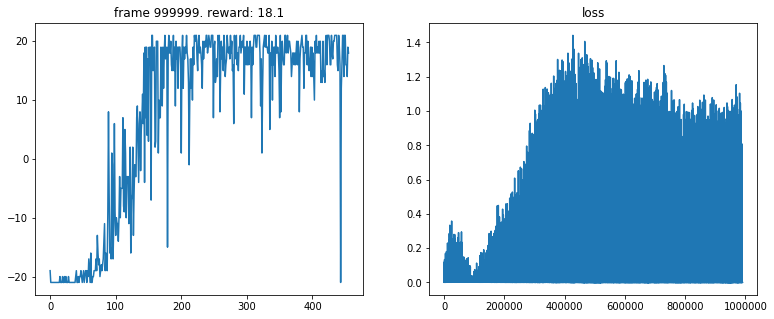

In [14]:
def plot_training(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

plot_training(i, all_rewards, losses)